In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
lo_stockdailyupdate = CRUD('stockdailyupdate')

In [13]:
df_stocks = lo_stockdailyupdate.Read('')

In [14]:
df_stocks.shape

(6172584, 9)

In [15]:
df_stocks.head(5)

,StockExchange,Symbol,Date,open,high,low,close,volume,delivery
0,BSE,500008,2015-09-14,850.326,879.928,848.507,867.923,38963,0
1,BSE,500008,2015-09-15,859.420,876.699,857.192,874.608,14756,0
2,BSE,500008,2015-09-16,877.609,895.434,866.514,870.242,16127,0
3,BSE,500008,2015-09-17,870.242,870.242,870.242,870.242,0,0
4,BSE,500008,2015-09-18,887.613,937.495,879.200,923.081,50221,0


In [17]:
df_stocks.isnull().sum()

StockExchange    0
Symbol           0
Date             0
open             0
high             0
low              0
close            0
volume           0
delivery         0
dtype: int64

In [18]:
# Filter for one stock (or loop for multiple later)
df = df_stocks[df_stocks['Symbol'] == 'VEDL'].copy()

# Sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [19]:
df.shape

(4908, 9)

In [22]:
df.columns

Index(['StockExchange', 'Symbol', 'Date', 'open', 'high', 'low', 'close',
       'volume', 'delivery'],
      dtype='object')

In [23]:
features = ['open', 'high', 'low', 'close', 'volume'] #, 'RSI', 'MA_20', 'MA_50']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [25]:
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_df)):
    X.append(scaled_df.iloc[i-lookback:i].values)
    y.append(scaled_df.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

X shape: (4848, 60, 5)
y shape: (4848,)


In [26]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [38]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output (predicting next-day price)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Projects\Market\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0017 - val_loss: 8.2328e-04
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.2650e-04 - val_loss: 0.0012
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.7990e-04 - val_loss: 8.4666e-04
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.1823e-04 - val_loss: 7.5037e-04
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.1062e-04 - val_loss: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.9041e-04 - val_loss: 2.0461e-04
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.8217e-04 - val_loss: 9.0974e-04
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.3128e-04 - val_loss: 0.0023
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.0022e-04 - val_loss: 0.0018
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.2870e-04 - val_loss: 0.0014
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.0654e-04 -

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


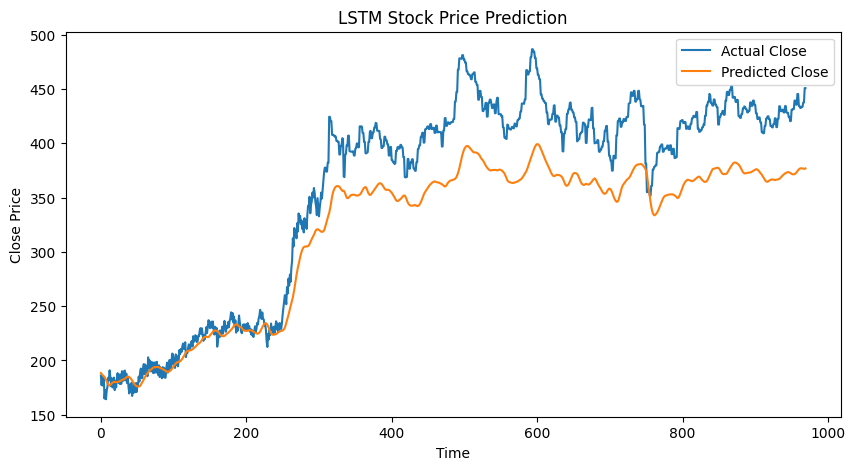

In [41]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 2142.0414
RMSE: 46.2822
MAE : 39.6487
R²  : 0.7584


In [42]:
from sklearn.metrics import accuracy_score

In [43]:
accuracy_score(y_test,y_pred)

ValueError: continuous is not supported

In [60]:
y_test.sort()

In [65]:
y_test.shape

(970,)

In [64]:
y_pred.shape

(970, 1)

In [47]:
df.isna().sum()

StockExchange    0
Symbol           0
Date             0
open             0
high             0
low              0
close            0
volume           0
delivery         0
dtype: int64

In [58]:
df[df['close']<=21]

,StockExchange,Symbol,Date,open,high,low,close,volume,delivery
2227047,BSE,VEDL,2016-01-21,21.6808,21.7798,20.5093,20.6248,3629178,0
2227055,BSE,VEDL,2016-02-03,20.9548,21.1693,19.9319,20.3444,3514133,0
5967816,NSE,VEDL,2016-02-03,21.5382,21.6395,20.3735,20.8124,24379236,0
2227061,BSE,VEDL,2016-02-11,21.7798,22.1263,20.2949,20.5753,2299486,0
2227062,BSE,VEDL,2016-02-12,21.0208,21.3343,19.1729,20.8888,5414022,0


In [ ]:
from breeze_connect import BreezeConnect